# Bayesian Network Mixture (BNM) model

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://pyagrum.gitlab.io) |[ ![interactive online version](images/atbinder.svg)](https://mybinder.org/v2/gl/agrumery%2FaGrUM/forBinder?urlpath=%2Fdoc%2Ftree%2Fwrappers%2Fpyagrum%2Fdoc%2Fsphinx%2Fnotebooks%2F73-PyModels_BNMixture.ipynb)

BNMixture represents a collection of ponderated BNs on the same domain (i.e. the same variables). Two main use can be found to such an object that implies two different classes :
- `BNMixture` : The goal is really to represent a mixture in the form :
  $$P(X_1,\cdots,X_n)=\sum_{i=1}^n \mu_i*P_{BN_i}(X1,\cdots,X_n)$$
  with $\sum_i \mu_i=1$
- `BootstrapMixture` : This mixture represents a collection of bootstrapped BNs learnerd from a single database. The goal here is to infere statitics on the learned BN (belief in a specific arc, confidence intervall for posterior, etc.)

## Model

Both inherit a mother class **IMixture**, most functions are the same, the main difference is the purpose. For instance, in the two classes, there is a reference BN which has not the same semantic : in a `BNMixture`, it is just the first added BN; in the `BootstrapMixture`, the reference is not part of the collection and represent the BN using the whole database.

|                   | BNMixture    | BootstrapMixture |
| ----------------- | ------------ | ---------------- |
|modify reference BN| Yes(but name)          | No               |
| __init__ parameters   | None    | Reference BN             |
| can contain a BN with same name as ref BN | No | No |

Note that the weights are not normalized automatically. The normalization is done lazily when necesssary or when asked.

## Inference
- IMixtureInference : Interface.
- BNMixtureInference : Compute inference as a weighted mean of all BNs inference.
- BootstrapMixtureInference : Compute inference of the reference BN. The other BNs are used as a confidence indicator for learned parameters.

## Learning

To understand the necessity of having these 2 objects, let's illustrate how we wish to use them.
- IMixtureLearner : Interface.
- BNMLearner : We start with $\textbf{N}$ databases and $\textbf{N}$ weights (one for each). Each database allows to learn a BN with a given weight. We fill the Mixture with them.
- BNMBootstrapLearner : We start with **one** database. From this real sample, we learn the reference BN. Then we generate $B$ other databases using *bootstrap* sampling method. 
They all have the same weight when added to the Mixture.

If a BN to add has the same structure and parameters as another one already present in the Mixture, we sum the weights and keep the BN already present.

## class `BNMixture`

Stores many BNs. The first BN to be added is the default reference BN. Method `updateRef` changes the reference BN (the one with max weight).

### Creating a BNMixture (`init`, `add`)

In [1]:
import pyagrum as gum
import pyagrum.bnmixture as BNM

import pyagrum.bnmixture.notebook as bnmnb
import pyagrum.lib.notebook as gnb

bn0 = gum.fastBN("A->C<-B")
bn1 = gum.BayesNet(bn0)
bn2 = gum.BayesNet(bn0)
bn1.addArc("A", "B")
bn2.addArc("B", "A")
bn1.generateCPTs()  # random CPTs for BN1
bn2.generateCPTs()  # random CPTs for BN2

bnm = BNM.BNMixture()
bnm.add("bn0", bn0, w=1.0)
bnm.add("bn1", bn1, w=2.0)
bnm.add("bn2", bn2, w=3.0)

print(bnm)

(reference BN : refBN), (bn0, w=1.0), (bn1, w=2.0), (bn2, w=3.0)


In [2]:
bn3 = gum.BayesNet(bn2)
bnm.add("bn3", bn3, w=1.5)
print(bnm)

(reference BN : refBN), (bn0, w=1.0), (bn1, w=2.0), (bn2, w=4.5)


### Other functions 
(`setWeight`, `weights`, `isNormalized`, `normalize`, `isValid`, `zeroBNs`, `existsArcs`, `variable`, `names`, `size`)

In [3]:
print("names : ", bnm.names())
print("weights : ", bnm.weights())
print("size : ", bnm.size())

bnm.setWeight("bn0", 1.1)

print("new weight of nb0 : ", bnm.weight("bn0"))
print("weights after change : ", bnm.weights())

names :  ['bn0', 'bn1', 'bn2']
weights :  {'bn0': 1.0, 'bn1': 2.0, 'bn2': 4.5}
size :  3
new weight of nb0 :  1.1
weights after change :  {'bn0': 1.1, 'bn1': 2.0, 'bn2': 4.5}


In [4]:
print("is the BNMixture normalized (sum(weights == 1))? : ", bnm.isNormalized())
bnm.normalize()
print("is the BNMixture normalized? : ", bnm.isNormalized())
print("weights after normalization : ", bnm.weights())
print("sum = ", sum(bnm.weights().values()))

is the BNMixture normalized (sum(weights == 1))? :  False
is the BNMixture normalized? :  True
weights after normalization :  {'bn0': 0.14473684210526316, 'bn1': 0.2631578947368421, 'bn2': 0.5921052631578948}
sum =  1.0


In [5]:
print("is the mixture valid (not all of the weights are 0)? :", bnm.isValid())

bnm.setWeight("bn0", 0)
bnm.setWeight("bn1", 0)
bnm.setWeight("bn2", 0)
print("is the mixture valid (not all of the weights are 0)? :", bnm.isValid())

bnm.setWeight("bn0", 1.1)
print("is the mixture valid (not all of the weights are 0)? :", bnm.isValid())

print("\nBNs with weight == 0 : ", bnm.zeroBNs())

is the mixture valid (not all of the weights are 0)? : True
is the mixture valid (not all of the weights are 0)? : False
is the mixture valid (not all of the weights are 0)? : True

BNs with weight == 0 :  {'bn1', 'bn2'}


In [6]:
print("how many arcs A->C among all BNs? :", bnm.existsArc("A", "C"))
print("how many arcs A->B among all BNs? :", bnm.existsArc("A", "B"))
print("how many arcs B->A among all BNs? :", bnm.existsArc("B", "A"))
print("how many arcs C->B among all BNs? :", bnm.existsArc("C", "B"))

how many arcs A->C among all BNs? : 3
how many arcs A->B among all BNs? : 1
how many arcs B->A among all BNs? : 1
how many arcs C->B among all BNs? : 0


In [7]:
print(bnm.variable("A"))

A:Range([0,1])


## class `BootstrapMixture`

Almost the same, the reference BN is handled differently. It cannot be updated.

In [8]:
bnm_boot = BNM.BootstrapMixture("bn0", bn0)
bnm_boot.add("bn1", bn1, w=1.0)
bnm_boot.add("bn2", bn2, w=2.0)
print(bnm_boot)

(reference BN : bn0), (bn1, w=1.0), (bn2, w=2.0)


Note : A BNMixture's reference BN always has the name "refBN" but BootstrapMixture's ref. BN can have any name when creating the object. 

## Inference

### class `BNMInference` (inference on BNMixture)

Here a posterior is the (normalized) weighted sum of all the posteriors.

In [9]:
bnm.setWeight("bn0", 1)
bnm.setWeight("bn1", 2)
bnm.setWeight("bn2", 1)

# def inModel(p,model):
#    q=gum.Potential()
#    for i in p.v

In [10]:
bnm_ie = BNM.BNMixtureInference(bnm, engine=gum.LazyPropagation)

bnm_ie.makeInference()
p = bnm_ie.posterior("C")

p0 = gum.getPosterior(bn0, target="C", evs={})
p1 = gum.getPosterior(bn1, target="C", evs={})
p2 = gum.getPosterior(bn2, target="C", evs={})

posterior(C) in the mixture,posterior p0 in bn0,posterior p1 in bn1,posterior p2 in bn2,manually : (1*p0+2*p1+1*p2)/4

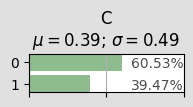
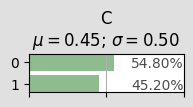
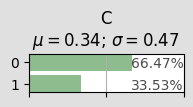
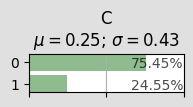
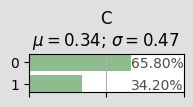

In [11]:
# p1.toVarsIn(p0) create a potential identical to p1 but with the variable from bn0
q = (p0 + 2 * p1.toVarsIn(bn0) + p2.toVarsIn(bn0)) / 4

gnb.sideBySide(
  gnb.getProba(p),
  gnb.getProba(p0),
  gnb.getProba(p1),
  gnb.getProba(p2),
  gnb.getProba(q),
  captions=[
    "posterior(C) in the mixture",
    "posterior p0 in bn0",
    "posterior p1 in bn1",
    "posterior p2 in bn2",
    "manually : (1*p0+2*p1+1*p2)/4",
  ],
)

### class `BootstrapMixtureInference` (inference on BootstrapMixture)

Here the posterior is the one of the reference BN. Other posteriors are used for other parameters such as quantiles, variance etc...

In [12]:
bnm_ie_boot = BNM.BootstrapMixtureInference(bnm_boot)
bnm_ie_boot.makeInference()
p = bnm_ie_boot.posterior("C")
gnb.sideBySide(p)

In [13]:
q = bnm_ie_boot.quantiles("C")
gnb.sideBySide(q[0], q[1], captions=["quantile 20%", "quantile 80%"])

Uncolored since values don't sum to 1.

## Learning BNMixture Models

### learning BNMixture : class `BNMLearner`
Example for BNMixtures. Using a different database for each instance.

In [14]:
new_bn = gum.fastBN("A->C<-B")

generator = gum.BNDatabaseGenerator(new_bn)
data = []
weights = [1 for i in range(5)]
for i in range(5):
  generator.drawSamples(50000)
  data.append(generator.to_pandas())

learner = BNM.BNMLearner(weights, data, template=new_bn)
learned_bnm = learner.learnBNM()

learned_bnm.updateRef()
bnmnb.showMixtureGraph(learned_bnm, ref=True)
print(learned_bnm)

(reference BN : refBN), (bn0, w=1), (bn1, w=1), (bn2, w=1), (bn3, w=1), (bn4, w=1)


### learning BootstrapMixture : class `BNMBootstrapLearner`
Example for BootstrapMixtures. Using one database only.

In [15]:
generator.drawSamples(5000)
refsample = generator.to_pandas()

refsample

,A,C,B
0,0,1,1
1,0,0,0
2,1,0,0
3,1,0,1
4,1,1,1
...,...,...,...
4995,0,1,1
4996,0,0,0
4997,1,0,0
4998,0,1,1


In [16]:
boot_learner = BNM.BNMBootstrapLearner(refsample, template=new_bn)
boot_learner.useIter(6)
learned_boot = boot_learner.learnBNM()

In [17]:
bnmnb.showMixtureGraph(learned_boot, ref=True)

## Graphical tools

In [18]:
bnmnb.showMixtureGraph(learned_bnm, ref=False)
bnmnb.showMixtureGraph(bnm, ref=True)

In [19]:
bnmnb.showBNMixtureInference(learned_bnm)
bnmnb.showBNMixtureInference(bnm)

In [20]:
bnmnb.showBootstrapMixtureInference(bnm_boot, quantiles=True)

### Arc comparison : confidence

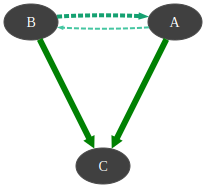

In [21]:
bnmnb.showComparison(bnm_boot, refStruct=True)

One of the features of BNMs is the possibility to graphicaly compare the arcs of all the BNs in a mixture. For each arc there is a confidence value between 0 and 1 describing how much an arc appears in the BNM, this value is a weighted mean, using the weight of each BN.
Arcs that appear in the reference BN are filled while arcs appearing in others BNs but not in the reference one are dashed. The more confidence we have in an arc, the darker its color gets.

In [22]:
gnb.flow.clear()
gnb.flow.add(bnmnb.getArcsComparison(bnm_boot, refStruct=True))
gnb.flow.add(bnmnb.arcsCompLegend())
gnb.flow.add(bnmnb.getArcsComparison(learned_bnm, refStruct=True))
gnb.flow.display()

In [23]:
gnb.flow.clear()
gnb.flow.add(bnmnb.getArcsComparison(bnm_boot, refStruct=False))
gnb.flow.add(bnmnb.arcsCompLegend())
gnb.flow.add(bnmnb.getArcsComparison(learned_bnm, refStruct=False))
gnb.flow.display()